# Illustration of JAX-cosmo on a DES Y1-like analysis

In [2]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# %pylab inline
import os.path
import jax
import jax.numpy as np
# get absolute path of this file:
path_here = os.path.abspath('')

parent_dir = os.path.abspath(os.path.join(path_here, '../'))

# get absolute path of the parent directory:
sys.path.append(parent_dir)
print(parent_dir)
import jax_cosmo_update as jc
import matplotlib.pyplot as pl
%load_ext autoreload
%autoreload 2




/mnt/ceph/users/spandey/jax_cosmo
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'):
    !wget https://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/datavectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits

# nz_source=fits.getdata('2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits', 6)
df = fits.open('2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
nz_source = df['nz_source'].data




Text(0.5, 1.0, 'Source redshift distributions')

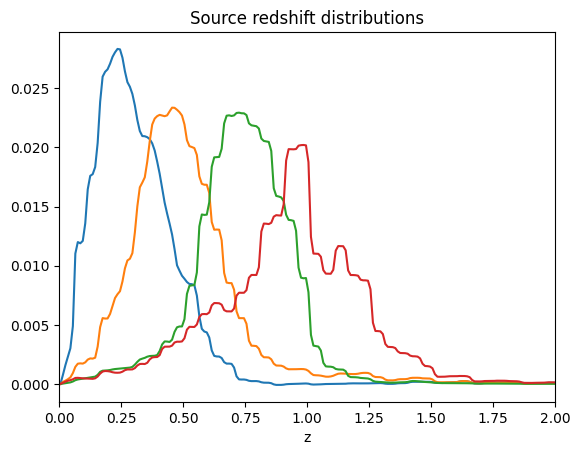

In [4]:
import matplotlib.pyplot as plt
# Let's plot the NZs
plt.figure()
plt.plot(nz_source['Z_MID'], nz_source['BIN1'])
plt.plot(nz_source['Z_MID'], nz_source['BIN2'])
plt.plot(nz_source['Z_MID'], nz_source['BIN3'])
plt.plot(nz_source['Z_MID'], nz_source['BIN4'])
plt.xlim(0,2);
plt.xlabel('z')
plt.title('Source redshift distributions')




In [5]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.476, 1.479, 1.484, 1.461]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]





(0.0, 2.0)

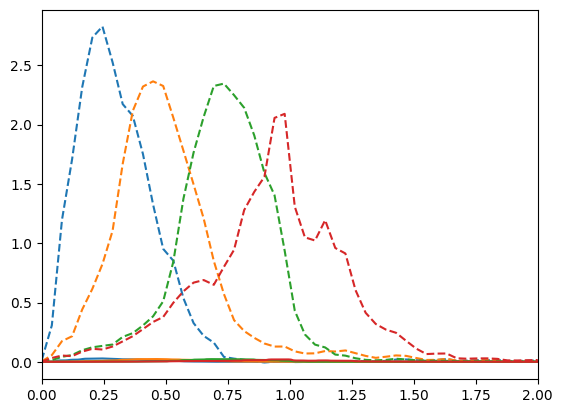

In [6]:
z = np.linspace(0,2)
plt.figure()
for i in range(4):
    plt.plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plt.plot(z, nzs_s[i](z), '--', color='C%d'%i)

plt.xlim(0,2)




##  Let's build  a model for C_ell

In [7]:
# First, let's define a function to go to and from a 1d parameter vector
# This function also accepts the alpha parameters
def get_params_vec(cosmo, m, dz, ia, alpha_k_params, alpha_z_params):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    g1, g2, pk = alpha_k_params
    beta, pz = alpha_z_params
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
        # alpha_k params
        g1, g2, pk,
        # alpha_z params
        beta, pz
    ])

# this is the original function without any alpha parameters
def get_params_vec_orig(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
    ])


def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    g1, g2, pk = params[16:19]
    beta, pz = params[19:21]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], [g1,g2,pk], [beta,pz]

def unpack_params_vec_orig(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.], [0.8,0.9,3.], [0.1,0.2])
unpack_params_vec(p)


(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [Array(1., dtype=float32),
  Array(2., dtype=float32),
  Array(3., dtype=float32),
  Array(4., dtype=float32)],
 [Array(5., dtype=float32),
  Array(6., dtype=float32),
  Array(7., dtype=float32),
  Array(8., dtype=float32)],
 [Array(1., dtype=float32), Array(2., dtype=float32)],
 [Array(0.8, dtype=float32),
  Array(0.9, dtype=float32),
  Array(3., dtype=float32)],
 [Array(0.1, dtype=float32), Array(0.2, dtype=float32)])

In [9]:
# check that the impact of evolution is as expected:
k_matrix=np.logspace(-3,3,100)
z_matrix=np.linspace(0,4,100)

from jax import vmap
def alpha_k(k, g1=10000.0, g2=10000.0, pk=1):
    num = (g1*k**pk)
    den = (1 + g2*k**pk)
    value = 1 - num/den
    return value

def alpha_z(z, beta=0.4, pz=1.0, Om=0.3):
    value = 1 - (beta/((1-Om) + Om*(1+z)**3))**pz
    return value    

def alpha_mat(k, z, g1=1.5, g2=1.5, pk=0.9, beta=0.2, pz=0.5, Om=0.3):
    alpha_kz = alpha_k(k, g1, g2, pk)
    alpha_zz = alpha_z(z, beta, pz, Om)
    return alpha_kz*alpha_zz


func1 = vmap(alpha_mat, in_axes=(0, None))
func2 = vmap(func1, in_axes=(None, 0))
alpha_mat = func2(k_matrix, z_matrix).T



Text(0.5, 1.0, '$\\alpha(k,z)$, such that $P_{mm} = \\alpha(k,z) \\times P_{\\rm \\Lambda CDM}$')

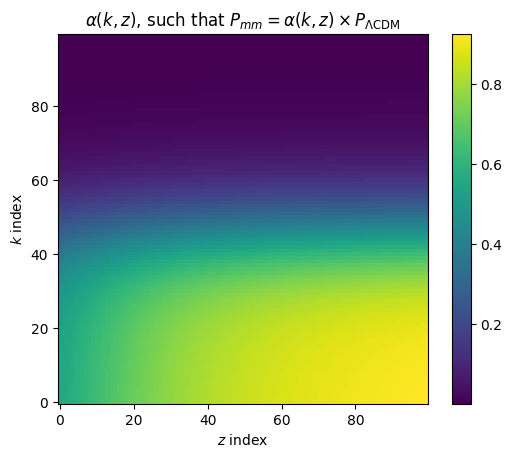

In [15]:
# at low k and high z, total alpha is close to 1
pl.figure()
pl.imshow((alpha_mat), origin='lower')
pl.xlabel(r'$z$ index')
pl.ylabel(r'$k$ index')
pl.colorbar()
pl.title(r'$\alpha(k,z)$, such that $P_{mm} = \alpha(k,z) \times P_{\rm \Lambda CDM}$')


In [16]:
# Define some ell range
ell = np.logspace(1, 4, 100)
from jax_cosmo_update import angular_cl


@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec_orig(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    cl = angular_cl.angular_cl(cosmo, ell, probes, matrix_params=alpha_mat, k_matrix=k_matrix, z_matrix=z_matrix)

    return cl

def mu_orig(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec_orig(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    cl = angular_cl.angular_cl(cosmo, ell, probes, matrix_params=np.ones_like(alpha_mat), k_matrix=k_matrix, z_matrix=z_matrix)

    return cl




In [17]:
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()
fid_params = get_params_vec_orig(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.])







In [18]:
cl_signal = mu(fid_params)
cl_signal_orig = mu_orig(fid_params)


/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

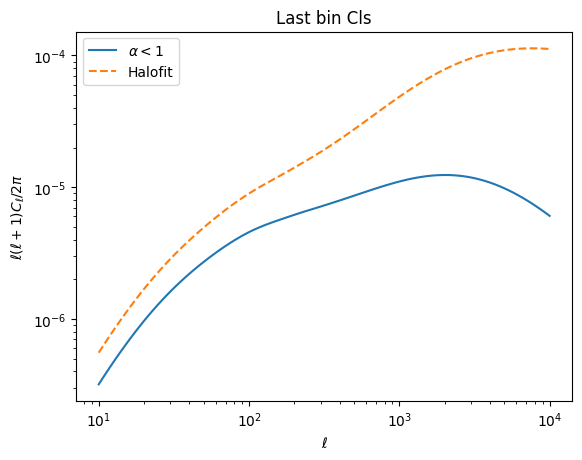

In [21]:
# ell
prefac = ell*(ell+1)/(2*np.pi)
pl.figure()
pl.plot(ell, prefac*cl_signal[9,:], label=r'$\alpha < 1$')
pl.plot(ell, prefac*cl_signal_orig[9,:], ls='--', label=r'Halofit')
pl.legend()
pl.axhline(0, color='k', ls=':')
pl.title('Last bin Cls')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')



Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

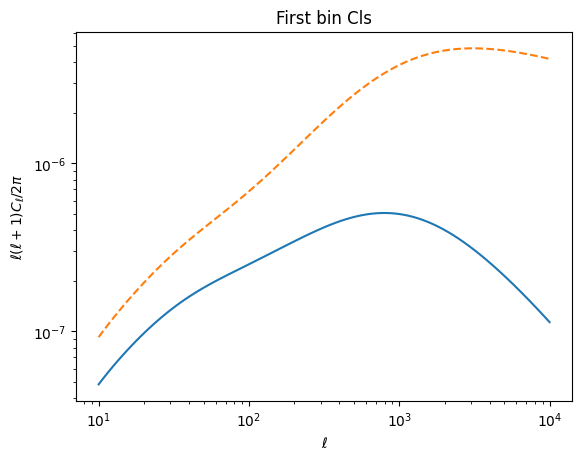

In [18]:
prefac = ell*(ell+1)/(2*np.pi)

pl.figure()
pl.plot(ell, prefac*cl_signal[0,:])
pl.plot(ell, prefac*cl_signal_orig[0,:], ls='--')
pl.title('First bin Cls')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')


In [22]:
from jax import vmap

@jax.jit
def mu_sample(params):
    # First unpack parameter vector
    # [g1,g2,pk], [beta,pz]
    cosmo, m, dz, (A, eta), (g1,g2,pk), (beta,pz) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    

    k_matrix=np.logspace(-3,3,400)
    z_matrix=np.linspace(0,4,100)
    Om = params[1]+params[2]

    def alpha_k(k, g1=g1, g2=g2, pk=pk):
        num = (g1*k**pk)
        den = (1 + g2*k**pk)
        value = 1 - num/den
        return value

    def alpha_z(z, beta=beta, pz=pz, Om=Om):
        value = 1 - (beta/((1-Om) + Om*(1+z)**3))**pz
        return value    

    def alpha_mat(k, z, g1=g1, g2=g2, pk=pk, beta=beta, pz=pz, Om=Om):
        alpha_kz = alpha_k(k, g1, g2, pk)
        alpha_zz = alpha_z(z, beta, pz, Om)
        return alpha_kz*alpha_zz

    func1 = vmap(alpha_mat, in_axes=(0, None))
    func2 = vmap(func1, in_axes=(None, 0))
    alpha_mat = func2(k_matrix, z_matrix).T

    cl = angular_cl.angular_cl(cosmo, ell, probes, matrix_params=alpha_mat, k_matrix=k_matrix, z_matrix=z_matrix)

    return cl



In [23]:
## Let's get the covariance
f_sky = 1321./41253.
print("f_sky", f_sky)
@jax.jit
def cov(params):
    
    cl_signal = mu_sample(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), (g1,g2,pk), (beta,pz) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov


    

f_sky 0.03202191355780186


In [24]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu_sample(p).flatten()))



In [25]:
# Let's try it out
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()
# g1=1.5, g2=1.5, pk=0.9, beta=0.3, pz=0.5
fid_params = get_params_vec(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.], [0.1, 1.5, 0.9], [0.1,0.5])




In [26]:
cl_wl = mu_sample(fid_params)


/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [27]:
%timeit mu_sample(fid_params).block_until_ready()


13.5 ms ± 6.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
C = cov(fid_params)


In [29]:
j = jacobian(fid_params)


In [30]:
#%timeit jacobian(fid_params).block_until_ready()
C.shape, j.shape


((1000, 1000), (1000, 21))

In [31]:
# And we get the fisher matrix from the jacobian and covariance
F = np.einsum('ia,ij,jb',j,np.linalg.inv(C),j)





In [32]:
# Add priors to systematics
import numpy as onp
d = onp.zeros(21)
d[6] = 1./(0.0091)**2
d[7] = 1./(0.0078)**2
d[8] = 1./(0.0076)**2
d[9] = 1./(0.0076)**2
d[10] = 1./(0.018)**2
d[11] = 1./(0.015)**2
d[12] = 1./(0.011)**2
d[13] = 1./(0.017)**2


d[16] = 1./(0.001)**2
d[17] = 1./(0.001)**2
d[18] = 1./(0.001)**2
d[19] = 1./(0.001)**2
d[20] = 1./(0.001)**2

F_tight = F + np.diag(d)




In [42]:
# Add priors to systematics
import numpy as onp
d = onp.zeros(21)
d[6] = 1./(0.0091)**2
d[7] = 1./(0.0078)**2
d[8] = 1./(0.0076)**2
d[9] = 1./(0.0076)**2
d[10] = 1./(0.018)**2
d[11] = 1./(0.015)**2
d[12] = 1./(0.011)**2
d[13] = 1./(0.017)**2

d[16] = 1./(1)**2
d[17] = 1./(1)**2
d[18] = 1./(1)**2
d[19] = 1./(1)**2
d[20] = 1./(1)**2


F_mid = F + np.diag(d)


In [48]:
import numpy as onp
d = onp.zeros(21)
d[6] = 1./(0.0091)**2
d[7] = 1./(0.0078)**2
d[8] = 1./(0.0076)**2
d[9] = 1./(0.0076)**2
d[10] = 1./(0.018)**2
d[11] = 1./(0.015)**2
d[12] = 1./(0.011)**2
d[13] = 1./(0.017)**2

d[16] = 1./(3)**2
d[17] = 1./(3)**2
d[18] = 1./(3)**2
d[19] = 1./(3)**2
d[20] = 1./(3)**2


F_low = F + np.diag(d)

In [49]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy import linalg
from math import degrees, sqrt
def plot_contours(fisher, pos, inds=[1,0], nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  i,j = inds
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  block_cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(block_cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  # print(pos[i,j], width, height, theta)
  # ellip = Ellipse(xy=pos[[i,j]], width=width,
  #                 height=height, angle=theta, **kwargs)
  ellip = Ellipse(xy=(pos[i], pos[j]), width=width,
                  height=height, angle=theta, **kwargs)  

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(i)
  s2 = 1.5*nstd*sigma_marg(j)
  ax.set_xlim(pos[i] - s1, pos[i] + s1)
  ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip
  

  

Text(0.5, 1.0, 'Fisher forecast for DES Y3 1$\\times$2pt')

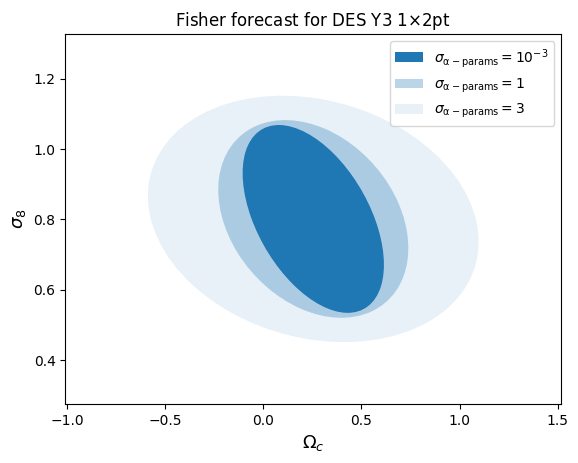

In [56]:
fig, ax = plt.subplots(1,1)
plot_contours(F_tight, fid_params, inds=[1,0], ax=ax, label=r'$\sigma_{\rm \alpha-params} = 10^{-3}$')
plot_contours(F_mid, fid_params, inds=[1,0], ax=ax, alpha=0.3, label=r'$\sigma_{\rm \alpha-params} = 1$')
plot_contours(F_low, fid_params, inds=[1,0], ax=ax, alpha=0.1, label=r'$\sigma_{\rm \alpha-params} = 3$')
pl.legend()
plt.xlabel(r'$\Omega_c$', size=13)
plt.ylabel(r'$\sigma_8$', size=13)
pl.title(r'Fisher forecast for DES Y3 1$\times$2pt')


## Fisher matrices are ok, but let's try proper inference

In [58]:
import numpyro
import numpyro.distributions as dist

/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
@jax.jit
def model_fn(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), (g1,g2,pk), (beta,pz) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    k_matrix=np.logspace(-3,3,400)
    z_matrix=np.linspace(0,4,100)
    Om = params[1]+params[2]

    def alpha_k(k, g1=g1, g2=g2, pk=pk):
        num = (g1*k**pk)
        den = (1 + g2*k**pk)
        value = 1 - num/den
        return value

    def alpha_z(z, beta=beta, pz=pz, Om=Om):
        value = 1 - (beta/((1-Om) + Om*(1+z)**3))**pz
        return value    

    def alpha_mat(k, z, g1=g1, g2=g2, pk=pk, beta=beta, pz=pz, Om=Om):
        alpha_kz = alpha_k(k, g1, g2, pk)
        alpha_zz = alpha_z(z, beta, pz, Om)
        return alpha_kz*alpha_zz

    func1 = vmap(alpha_mat, in_axes=(0, None))
    func2 = vmap(func1, in_axes=(None, 0))
    alpha_mat = func2(k_matrix, z_matrix).T

    cl = angular_cl.angular_cl(cosmo, ell, probes, matrix_params=alpha_mat, k_matrix=k_matrix, z_matrix=z_matrix)

    return cl.flatten()




In [60]:
# Let's define our model using numpyro
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.9))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.97))
#     w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))
    w0 = -1.0
    
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    
    # Astrophysical params
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))

    # alpha_k params
    g1 = numpyro.sample('g1', dist.Uniform(0.0, 1.5))
    g2 = numpyro.sample('g2', dist.Uniform(0.0, 1.5))
    pk = numpyro.sample('pk', dist.Uniform(0.0, 1.5))

    # alpha_z params
    beta = numpyro.sample('beta', dist.Uniform(0.0, 1.5))
    pz = numpyro.sample('pz', dist.Uniform(0.0, 1.5))

    
    # Now that params are defined, here is the forward model
    cosmo = FiducialCosmo(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0)
    
    signal = model_fn(get_params_vec(cosmo, m, [dz1, dz2, dz3, dz4], [A, eta], [g1,g2,pk], [beta,pz]))
    
    # And here we define the likelihood
    numpyro.sample('cl_wl', dist.MultivariateNormal(signal, C))


    

In [61]:
from numpyro.handlers import seed, trace
rng_key = jax.random.PRNGKey(0)

In [62]:
tr = numpyro.handlers.trace(seed(model, rng_key))

In [63]:
res = tr.get_trace()

/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [64]:
data = res['cl_wl']['value']

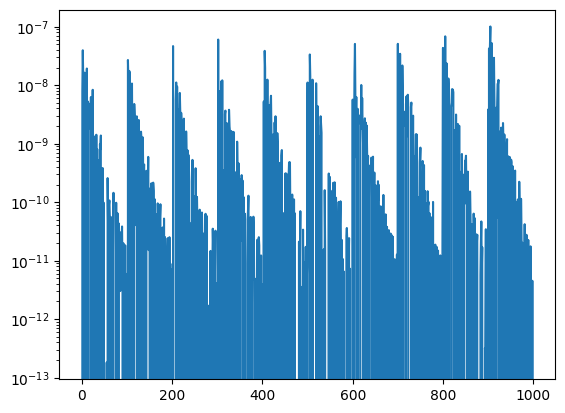

In [66]:
pl.figure()
pl.semilogy(data)


In [67]:
cond_model = numpyro.handlers.condition(model, {'cl_wl':data})

In [68]:
nuts_kernel = numpyro.infer.NUTS(cond_model)

In [69]:
rng_key = jax.random.PRNGKey(0)

In [70]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=500, 
                          num_samples=1000,
                          jit_model_args=True)

In [71]:
mcmc.run(rng_key, extra_fields=('potential_energy',))


warmup:   2%|▏         | 31/1500 [10:17<44:48:20, 109.80s/it, 1023 steps of size 4.69e-03. acc. prob=0.71]